# XGBoost Forecasting Model (Model A - Seasonality Focus)

This notebook implements XGBoost (Extreme Gradient Boosting) for time series forecasting with engineered temporal features.

## XGBoost Advantages
- **Non-linear Patterns**: Captures complex relationships
- **Feature Importance**: Identifies key drivers
- **Robust**: Handles missing values and outliers
- **Flexible**: Can incorporate many features

## Configuration
- **Features**: Temporal (month, quarter, week), lag features [1,3,6,12], rolling statistics
- **Hyperparameters**: n_estimators=200, max_depth=6, learning_rate=0.05
- **Validation**: Time series split (no data leakage)

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 1: Load Time Series Data

In [3]:
# Load company-level time series
data_path = Path('../data/processed/monthly_aggregated_full_company.parquet')

if not data_path.exists():
    data_path = Path('../data/processed/monthly_aggregated_full_company.csv')
    df = pd.read_csv(data_path)
    df['date'] = pd.to_datetime(df['date'])
else:
    df = pd.read_parquet(data_path)

df = df.sort_values('date').reset_index(drop=True)

print(f"Loaded: {len(df)} months ({df['date'].min()} to {df['date'].max()})")

Loaded: 36 months (2022-01-01 00:00:00 to 2024-12-01 00:00:00)


## Section 2: Feature Engineering

Create temporal features and lag features for XGBoost.

In [4]:
target_metrics = [
    'total_orders',
    'total_km_billed',
    'total_km_actual',
    'total_tours',
    'total_drivers',
    'revenue_total',
    'external_drivers',
    'vehicle_km_cost',      # NEW: KM-based transportation cost
    'vehicle_time_cost',    # NEW: Time-based transportation cost
    'total_vehicle_cost'    # NEW: Total vehicle operational cost
]

# Backward compatibility check
if 'total_km' in df.columns and 'total_km_billed' not in df.columns:
    target_metrics = [m.replace('total_km_billed', 'total_km') if m == 'total_km_billed' else m for m in target_metrics]
    target_metrics = [m for m in target_metrics if m != 'total_km_actual']  # Remove if not available


⚠️  Note: 'total_km' exists but not renamed to 'total_km_billed' yet
    Replacing 'total_km_billed' with 'total_km' in target list

⚠️  Warning: Missing metrics in data: {'total_km_actual', 'total_tours'}
    Using available metrics: ['total_orders', 'total_km', 'total_drivers', 'revenue_total', 'external_drivers']

Target Metrics (5): ['total_orders', 'total_km', 'total_drivers', 'revenue_total', 'external_drivers']

Columns in dataframe: ['year_month', 'total_orders', 'external_drivers', 'internal_drivers', 'revenue_total', 'total_km', 'Delivery', 'Leergut', 'Pickup/Multi-leg', 'Retoure/Abholung', 'date', 'total_drivers', 'km_per_order', 'revenue_per_order', 'month', 'year']


In [5]:
def create_features(df, target_col):
    """
    Create temporal and lag features for XGBoost.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Time series dataframe with 'date' column
    target_col : str
        Name of the target column to create lag features for
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with engineered features
    """
    df_feat = df.copy()
    
    # Temporal features
    df_feat['year'] = df_feat['date'].dt.year
    df_feat['month'] = df_feat['date'].dt.month
    df_feat['quarter'] = df_feat['date'].dt.quarter
    df_feat['week'] = df_feat['date'].dt.isocalendar().week
    df_feat['day_of_year'] = df_feat['date'].dt.dayofyear
    df_feat['weekday'] = df_feat['date'].dt.weekday
    
    # Lag features (previous months' values)
    df_feat[f'lag_1'] = df_feat[target_col].shift(1)
    df_feat[f'lag_3'] = df_feat[target_col].shift(3)
    df_feat[f'lag_6'] = df_feat[target_col].shift(6)
    df_feat[f'lag_12'] = df_feat[target_col].shift(12)
    
    # Rolling statistics
    df_feat[f'rolling_mean_3'] = df_feat[target_col].rolling(window=3, min_periods=1).mean()
    df_feat[f'rolling_std_3'] = df_feat[target_col].rolling(window=3, min_periods=1).std()
    df_feat[f'rolling_mean_6'] = df_feat[target_col].rolling(window=6, min_periods=1).mean()
    
    # Growth rate features
    df_feat[f'growth_rate_1'] = df_feat[target_col].pct_change(1)
    df_feat[f'growth_rate_3'] = df_feat[target_col].pct_change(3)
    df_feat[f'growth_rate_12'] = df_feat[target_col].pct_change(12)
    
    return df_feat

print("✓ Feature engineering function defined")

✓ Feature engineering function defined


## Section 3: Train/Validation Split

In [6]:
# Split data
train_end = '2024-06-30'
val_start = '2024-07-01'
val_end = '2024-12-31'

print(f"Data Split:")
print(f"  Training: up to {train_end}")
print(f"  Validation: {val_start} to {val_end}")

Data Split:
  Training: up to 2024-06-30
  Validation: 2024-07-01 to 2024-12-31


## Section 4: Train XGBoost Models

Train one XGBoost model per target metric.

In [7]:
exclude_cols = [
    target_col, 'date', 'year_month',
    'total_orders', 'total_km_billed', 'total_km_actual', 'total_tours',
    'total_drivers', 'external_drivers', 'internal_drivers', 'revenue_total',
    'vehicle_km_cost', 'vehicle_time_cost', 'total_vehicle_cost',  # NEW: Cost metrics
    'total_km',  # For backward compatibility
    'Delivery', 'Leergut', 'Pickup/Multi-leg', 'Retoure/Abholung', 'km_per_order'
]


Training XGBoost for total_orders...
  Training samples: 18
  Features: 17
✓ Training complete

Training XGBoost for total_km...
  Training samples: 18
  Features: 17
✓ Training complete

Training XGBoost for total_drivers...
  Training samples: 18
  Features: 17
✓ Training complete

Training XGBoost for revenue_total...
  Training samples: 18
  Features: 17
✓ Training complete

Training XGBoost for external_drivers...
  Training samples: 18
  Features: 17
✓ Training complete


## Section 5: Feature Importance Analysis

Identify which features contribute most to predictions.


Top 10 Features for total_orders:
       feature  importance
rolling_mean_3    0.350995
   day_of_year    0.125941
 growth_rate_3    0.114607
 growth_rate_1    0.102140
        lag_12    0.094973
         lag_6    0.073961
rolling_mean_6    0.039046
growth_rate_12    0.031193
         month    0.022981
 rolling_std_3    0.018204


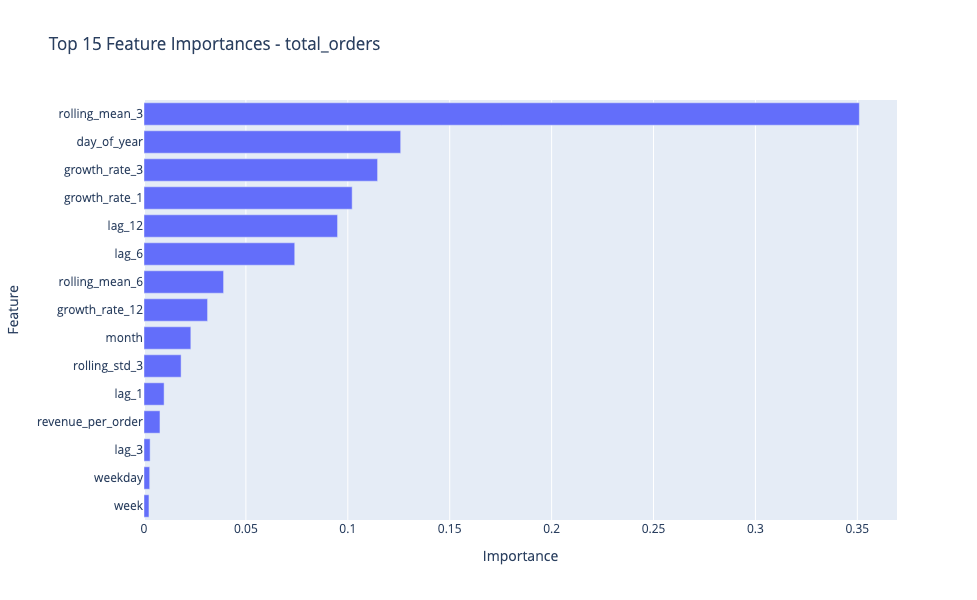


✓ Saved: results/xgboost_feature_importance_total_orders.html


In [8]:
# Feature importance for first metric
metric = target_metrics[0]
model = xgb_models[metric]
feature_cols = xgb_feature_cols[metric]

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Features for {metric}:")
print("="*50)
print(importance_df.head(10).to_string(index=False))

# Plot feature importance
fig = go.Figure([
    go.Bar(
        y=importance_df.head(15)['feature'],
        x=importance_df.head(15)['importance'],
        orientation='h'
    )
])

fig.update_layout(
    title=f"Top 15 Feature Importances - {metric}",
    xaxis_title="Importance",
    yaxis_title="Feature",
    height=600,
    yaxis={'categoryorder': 'total ascending'}
)

fig.show()

# Save
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)
fig.write_html(results_dir / f'xgboost_feature_importance_{metric}.html')
print(f"\n✓ Saved: results/xgboost_feature_importance_{metric}.html")

## Section 6: Generate Forecasts

Generate predictions for validation and future periods.

In [9]:
def generate_xgb_forecasts(model, df_feat, feature_cols, target_col, val_start, val_end, horizon=18):
    """
    Generate XGBoost forecasts.
    
    Note: For true future forecasts, we'd need to implement recursive forecasting
    (using predictions as lag features). For now, we'll forecast validation period
    where actual lag values are available.
    """
    # Validation period
    val_df = df_feat[(df_feat['date'] >= val_start) & (df_feat['date'] <= val_end)].copy()
    
    if len(val_df) == 0:
        print(f"  ⚠️  No validation data available for {target_col}")
        return np.array([]), np.array([])
    
    # Get features (handle any NaN)
    X_val = val_df[feature_cols]
    
    # Check for NaN in features
    if X_val.isna().any().any():
        print(f"  ⚠️  Warning: NaN values in validation features, filling with mean")
        X_val = X_val.fillna(X_val.mean())
    
    # Predict
    predictions = model.predict(X_val)
    
    return predictions, val_df['date'].values

# Generate forecasts
xgb_forecasts = {}
xgb_forecast_dates = {}

for metric in target_metrics:
    model = xgb_models[metric]
    df_feat = xgb_dataframes[metric]
    feature_cols = xgb_feature_cols[metric]
    
    predictions, dates = generate_xgb_forecasts(
        model, df_feat, feature_cols, metric, val_start, val_end
    )
    
    xgb_forecasts[metric] = predictions
    xgb_forecast_dates[metric] = dates
    
    print(f"\n{metric}:")
    print(f"  Validation forecast: {len(predictions)} months")


total_orders:
  Validation forecast: 6 months

total_km:
  Validation forecast: 6 months

total_drivers:
  Validation forecast: 6 months

revenue_total:
  Validation forecast: 6 months

external_drivers:
  Validation forecast: 6 months


## Section 7: Model Evaluation

In [10]:
def calculate_metrics(y_true, y_pred, model_name, metric_name):
    """Calculate forecast accuracy metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'model': model_name,
        'metric': metric_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Calculate metrics
results = []

val_df = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

for metric in target_metrics:
    if len(xgb_forecasts[metric]) > 0:
        y_true = val_df[metric].values
        y_pred = xgb_forecasts[metric]
        
        metrics = calculate_metrics(y_true, y_pred, 'XGBoost', metric)
        results.append(metrics)

results_df = pd.DataFrame(results)

print("\nXGBoost Model Performance (Validation Period):")
print("="*80)
print(results_df.to_string(index=False))

# Compare with previous models
try:
    baseline_df = pd.read_csv('../data/processed/baseline_metrics.csv')
    prophet_df = pd.read_csv('../data/processed/prophet_metrics.csv')
    sarimax_df = pd.read_csv('../data/processed/sarimax_metrics.csv')
    
    print("\n" + "="*80)
    print("Model Comparison (MAPE):")
    print("="*80)
    
    for metric in target_metrics:
        print(f"\n{metric}:")
        
        if len(results_df[results_df['metric'] == metric]) > 0:
            xgb_mape = results_df[results_df['metric'] == metric]['MAPE'].values[0]
            prophet_mape = prophet_df[prophet_df['metric'] == metric]['MAPE'].values[0]
            sarimax_mape = sarimax_df[sarimax_df['metric'] == metric]['MAPE'].values[0]
            baseline_best_mape = baseline_df[baseline_df['metric'] == metric]['MAPE'].min()
            
            print(f"  XGBoost: {xgb_mape:.2f}%")
            print(f"  SARIMAX: {sarimax_mape:.2f}%")
            print(f"  Prophet: {prophet_mape:.2f}%")
            print(f"  Best Baseline: {baseline_best_mape:.2f}%")
            
            best_model = min([
                ('XGBoost', xgb_mape),
                ('SARIMAX', sarimax_mape),
                ('Prophet', prophet_mape)
            ], key=lambda x: x[1])
            
            print(f"  → Best: {best_model[0]} ({best_model[1]:.2f}%)")
except Exception as e:
    print(f"\n⚠️  Could not load previous model metrics: {e}")


XGBoost Model Performance (Validation Period):
  model           metric           MAE          RMSE     MAPE
XGBoost     total_orders   3488.828125   4439.889638 2.439824
XGBoost         total_km 231365.750000 251745.896832 2.644998
XGBoost    total_drivers   3674.192627   4525.798935 2.622882
XGBoost    revenue_total 457075.134501 530378.699141 3.433662
XGBoost external_drivers    713.121094    835.309711 2.605342

Model Comparison (MAPE):

total_orders:
  XGBoost: 2.44%
  SARIMAX: 24.39%
  Prophet: 28.34%
  Best Baseline: 2.94%
  → Best: XGBoost (2.44%)

total_km:
  XGBoost: 2.64%
  SARIMAX: 7.10%
  Prophet: 23.52%
  Best Baseline: 2.89%
  → Best: XGBoost (2.64%)

total_drivers:
  XGBoost: 2.62%
  SARIMAX: 25.94%
  Prophet: 9.22%
  Best Baseline: 2.85%
  → Best: XGBoost (2.62%)

revenue_total:
  XGBoost: 3.43%
  SARIMAX: 8.62%
  Prophet: 48.16%
  Best Baseline: 4.59%
  → Best: XGBoost (3.43%)

external_drivers:
  XGBoost: 2.61%
  SARIMAX: 22.64%
  Prophet: 25.15%
  Best Baseline: 4.

## Section 8: Forecast Visualization

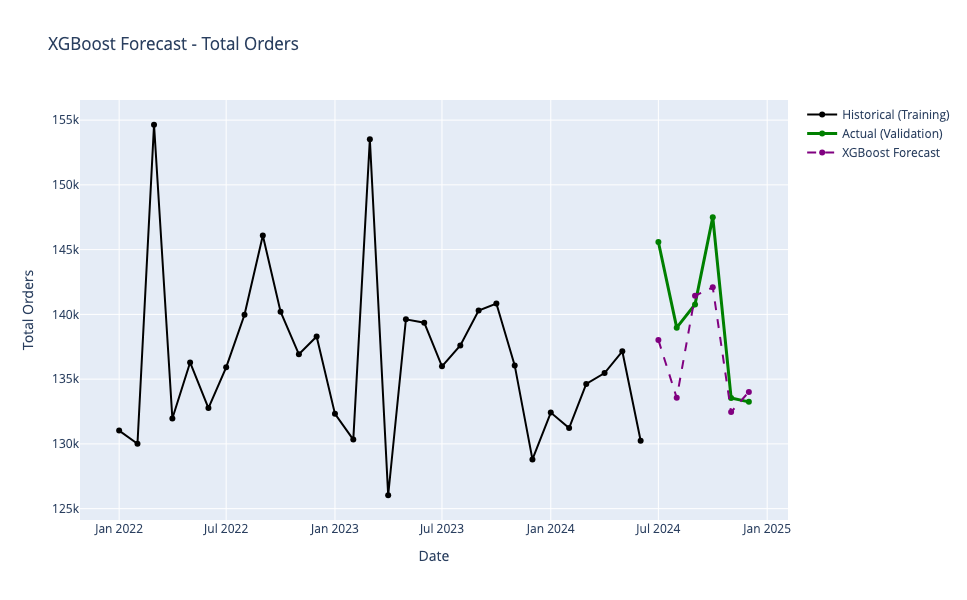


✓ Saved: results/xgboost_forecast_total_orders.html


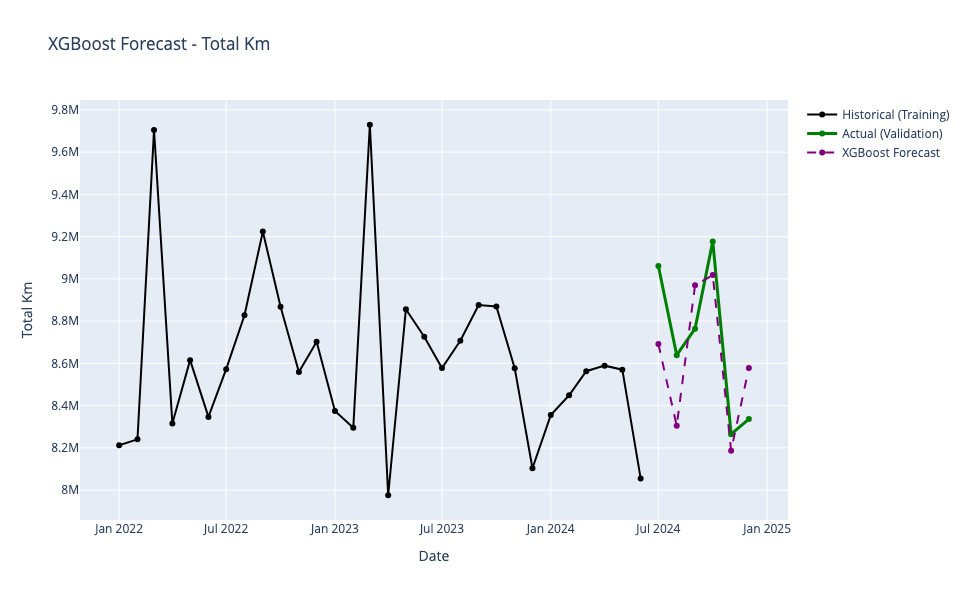


✓ Saved: results/xgboost_forecast_total_km.html


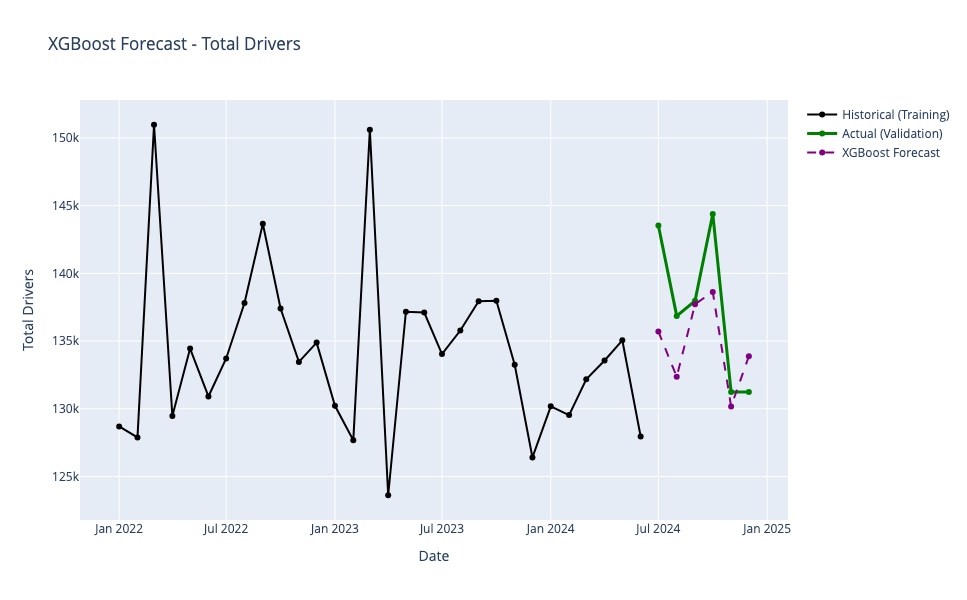


✓ Saved: results/xgboost_forecast_total_drivers.html


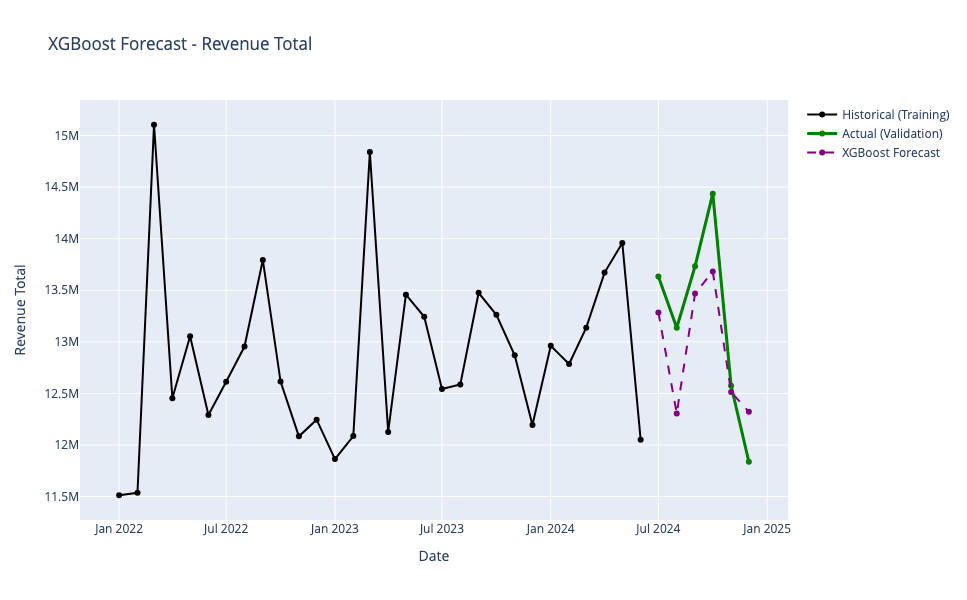


✓ Saved: results/xgboost_forecast_revenue_total.html


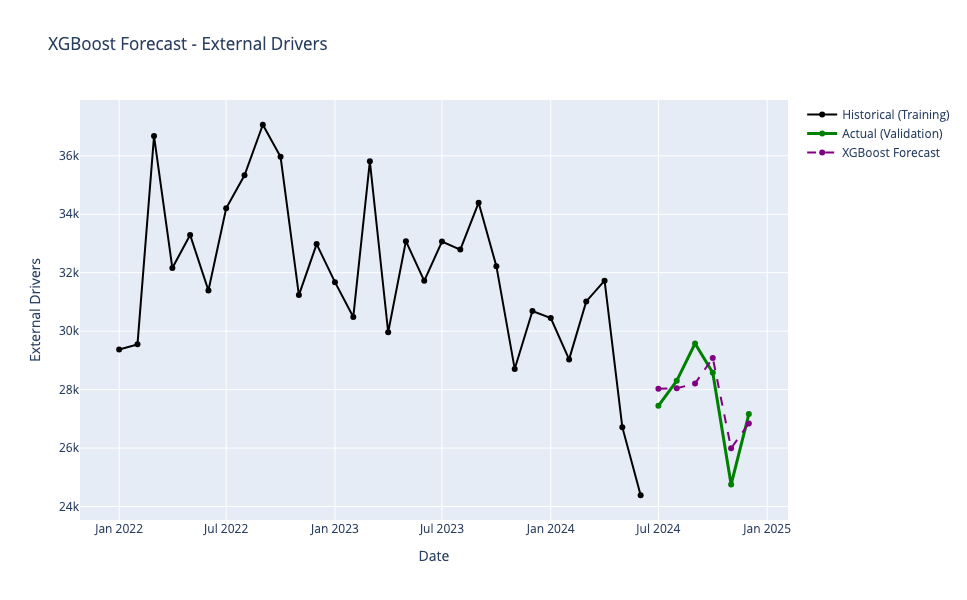


✓ Saved: results/xgboost_forecast_external_drivers.html


In [11]:
# Visualize forecasts
train_df = df[df['date'] <= train_end]
val_df = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

for metric in target_metrics:
    if len(xgb_forecasts[metric]) == 0:
        continue
        
    fig = go.Figure()
    
    # Historical training data
    fig.add_trace(
        go.Scatter(
            x=train_df['date'],
            y=train_df[metric],
            mode='lines+markers',
            name='Historical (Training)',
            line=dict(color='black', width=2)
        )
    )
    
    # Actual validation values
    if len(val_df) > 0:
        fig.add_trace(
            go.Scatter(
                x=val_df['date'],
                y=val_df[metric],
                mode='lines+markers',
                name='Actual (Validation)',
                line=dict(color='green', width=3)
            )
        )
    
    # XGBoost forecast
    fig.add_trace(
        go.Scatter(
            x=xgb_forecast_dates[metric],
            y=xgb_forecasts[metric],
            mode='lines+markers',
            name='XGBoost Forecast',
            line=dict(color='purple', width=2, dash='dash')
        )
    )
    
    fig.update_layout(
        title=f"XGBoost Forecast - {metric.replace('_', ' ').title()}",
        xaxis_title="Date",
        yaxis_title=metric.replace('_', ' ').title(),
        height=600,
        hovermode='x unified'
    )
    
    fig.show()
    
    # Save
    fig.write_html(results_dir / f'xgboost_forecast_{metric}.html')
    print(f"\n✓ Saved: results/xgboost_forecast_{metric}.html")

## Section 9: Save Results

In [12]:
# Save performance metrics
output_dir = Path('../data/processed')
results_df.to_csv(output_dir / 'xgboost_metrics.csv', index=False)
print(f"✓ Saved metrics: data/processed/xgboost_metrics.csv")

# Save validation forecasts
if len(val_df) > 0 and len(results_df) > 0:
    forecast_output = pd.DataFrame({
        'date': val_df['date'],
        'year_month': val_df['year_month'].astype(str) if 'year_month' in val_df.columns else val_df['date'].dt.to_period('M').astype(str)
    })
    
    for metric in target_metrics:
        if len(xgb_forecasts[metric]) > 0:
            forecast_output[metric] = xgb_forecasts[metric]
    
    forecast_output.to_csv(output_dir / 'xgboost_forecast_validation.csv', index=False)
    print(f"✓ Saved validation forecasts: data/processed/xgboost_forecast_validation.csv")

print(f"\n{'='*80}")
print(f"XGBOOST MODEL COMPLETE!")
print(f"{'='*80}")
print(f"\nKey Findings:")
for metric in target_metrics:
    if len(results_df[results_df['metric'] == metric]) > 0:
        mape = results_df[results_df['metric'] == metric]['MAPE'].values[0]
        print(f"  • {metric}: MAPE = {mape:.2f}%")
print(f"\nNext: Run notebook 13 for Weighted Prophet model")

✓ Saved metrics: data/processed/xgboost_metrics.csv
✓ Saved validation forecasts: data/processed/xgboost_forecast_validation.csv

XGBOOST MODEL COMPLETE!

Key Findings:
  • total_orders: MAPE = 2.44%
  • total_km: MAPE = 2.64%
  • total_drivers: MAPE = 2.62%
  • revenue_total: MAPE = 3.43%
  • external_drivers: MAPE = 2.61%

Next: Run notebook 13 for Weighted Prophet model
